# Fig. 3

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggpubr)
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(vcfR)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(patchwork)
    library(stringr)
    library(purrr)
    library(fitdistrplus)
    library(gridExtra)
    library(ggrastr)
    library(ggrepel)
    library(patchwork)
    library(viridis)
    require(gdata)
    library(readxl)
    library(coloc)
})

geno_df = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
geno_df$POS = as.numeric(geno_df$POS)

figures_dir = '../SuppFigs/'
source('../scripts/utils.R')

In [3]:
gtf_hla = readRDS('../eqtl_pseudobulk/gtf_hla.rds')
gtf_hla = gtf_hla %>% mutate(hla_gene = gene_name)
gtf_hla = gtf_hla %>% arrange(TSS)
gtf_hla$plot_pos = c(0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5)
gtf_hla

gene_name,gene,TSS,width,strand,hla_gene,plot_pos
<chr>,<chr>,<int>,<int>,<fct>,<chr>,<dbl>
HLA-A,HLA.A,29942245,3640,+,HLA-A,0.0
HLA-C,HLA.C,31272086,3338,-,HLA-C,0.5
HLA-B,HLA.B,31355404,904,-,HLA-B,0.0
HLA-DRB1,HLA.DRB1,32589848,11080,-,HLA-DRB1,0.5
HLA-DQA1,HLA.DQA1,32637401,6252,+,HLA-DQA1,0.0
HLA-DQB1,HLA.DQB1,32666664,7198,-,HLA-DQB1,0.5
HLA-DPA1,HLA.DPA1,33069248,1589,-,HLA-DPA1,0.0
HLA-DPB1,HLA.DPB1,33080487,5403,+,HLA-DPB1,0.5


# Plot lead eQTL effects

## Plotting functions

In [4]:
# Function that plots a single boxplot for an eQTL showing genotype dose response, colored by dataset
# Assumes lead_variants is present
# variant: variant to plot
# gene: eGene
# data: result from eQTL association test
# legend: plot the legend
eqtl_boxplot_dataset = function(variant, gene, data, legend = FALSE) {
    
    # Estimate the dataset effects to regress out
    colnames(data) = str_replace(colnames(data), 'HLA-', 'HLA\\.') # avoid using '-' character in lm call
    genedot = str_replace(gene, 'HLA-', 'HLA\\.')
    data$dataset = factor(data$dataset, levels = c('Randolph_NI', 'AMP2RA', 'OneK1K', 'Smillie')) # refactor to match model script
    mod = lm(as.formula(paste(genedot, ' ~ dataset + ', paste(variant, collapse = "+"), sep = "")), data = data)
    
    # Residualize out dataset effects
    data[which(data$dataset == 'Smillie'), genedot] = data[which(data$dataset == 'Smillie'), genedot] - 
                                                           summary(mod)$coeff['datasetSmillie', 'Estimate']
    data[which(data$dataset == 'AMP2RA'), genedot] = data[which(data$dataset == 'AMP2RA'), genedot] - 
                                                           summary(mod)$coeff['datasetAMP2RA', 'Estimate']
    data[which(data$dataset == 'OneK1K'), genedot] = data[which(data$dataset == 'OneK1K'), genedot] - 
                                                           summary(mod)$coeff['datasetOneK1K', 'Estimate']
    
    data$dataset = revalue(data$dataset, old_new_dataset_names)
    data$dataset = factor(data$dataset, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
    colnames(data) = str_replace(colnames(data), 'HLA\\.', 'HLA-') # add back '-' character in gene name
    
    # Plot the eQTL
    data[, variant] = as.factor(data[, variant])
    pval = lead_variants[which(lead_variants$variant == variant & lead_variants$gene == gene), 'p.val'] %>% unlist()
    beta = lead_variants[which(lead_variants$variant == variant & lead_variants$gene == gene), 'beta'] %>% unlist()
    subtitle = paste0('p = ', format(pval, digits = 3, scientific = TRUE),'; beta = ', format(beta, digits = 2))
    
    # Get REF/ALT alleles
    myREF = geno_df[which(geno_df$ID == variant), 'REF']
    myALT = geno_df[which(geno_df$ID == variant), 'ALT']
    data[, variant] = plyr::mapvalues(data[, variant], c(0, 1, 2), 
                            c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)
    
    # For long variant names, add newlines at 4th "_"
    variantn = variant
    if (startsWith(variantn, 'SNPS')){
            str_vec = strsplit(variantn, "_")[[1]] 
            where = seq_along(str_vec) == 4
            str_vec[where] = sub("", "\n", str_vec[where])
            variantn = paste(str_vec, collapse = "_")
    }
    
    fig.size(4, 4)
    p = ggplot(data) +
        geom_boxplot(aes(x = get(variant), y = get(gene), fill = dataset, col = dataset), outlier.size = 0.2) +
        geom_point_rast(aes(x = get(variant), y = get(gene), fill = dataset), 
                        size = 0.2, alpha = 0.4, position = position_jitterdodge()) +
        theme_classic() + ylab(paste(gene, 'residual')) + xlab(variantn) +
        labs(subtitle = subtitle) + theme(plot.subtitle=element_text(color = "grey48")) + 
        scale_color_manual(values = cohort_colors_darker) + scale_fill_manual(values = cohort_colors)
    
    if (legend == FALSE) { p = p + theme(legend.position = 'none') }
    return(p)
}

# Plots one boxplot for each classical HLA gene, colored by dataset
# Assumes "data" variable present
eqtl_boxplots_dataset = function(lead_variants) {
    p1 = eqtl_boxplot_dataset(unlist(lead_variants[1, 'variant']), unlist(lead_variants[1, 'gene']), data)
    p2 = eqtl_boxplot_dataset(unlist(lead_variants[2, 'variant']), unlist(lead_variants[2, 'gene']), data)
    p3 = eqtl_boxplot_dataset(unlist(lead_variants[3, 'variant']), unlist(lead_variants[3, 'gene']), data)
    p4 = eqtl_boxplot_dataset(unlist(lead_variants[4, 'variant']), unlist(lead_variants[4, 'gene']), data, legend = TRUE)
    p5 = eqtl_boxplot_dataset(unlist(lead_variants[5, 'variant']), unlist(lead_variants[5, 'gene']), data)
    p6 = eqtl_boxplot_dataset(unlist(lead_variants[6, 'variant']), unlist(lead_variants[6, 'gene']), data)
    p7 = eqtl_boxplot_dataset(unlist(lead_variants[7, 'variant']), unlist(lead_variants[7, 'gene']), data)
    p8 = eqtl_boxplot_dataset(unlist(lead_variants[8, 'variant']), unlist(lead_variants[8, 'gene']), data, legend = TRUE)
    
    fig.size(6, 12)
    (p1 | p2 | p3 | p4) / (p5 | p6 | p7 | p8)
}

thresh = -log10(5e-8) # significance threshold

## Myeloid example for HLA-DQA1

In [6]:
results = read.csv('../eqtl_pseudobulk/4_multidataset_eQTLs/Myeloid_pseudobulk_eQTLs.csv', row.names = 1)
results = merge(results, geno_df, by.x = 'variant', by.y = 'ID', all.x = T, all.y = F)
results = results %>% mutate(gene = str_replace(gene, '\\.', '-'), POS = as.numeric(POS)) %>% arrange(POS)
results$X = NULL

# Get lead variant for each cell type
lead_variants = results %>% group_by(cell_type, gene) %>% slice(which.min(p.val))

png 
  2

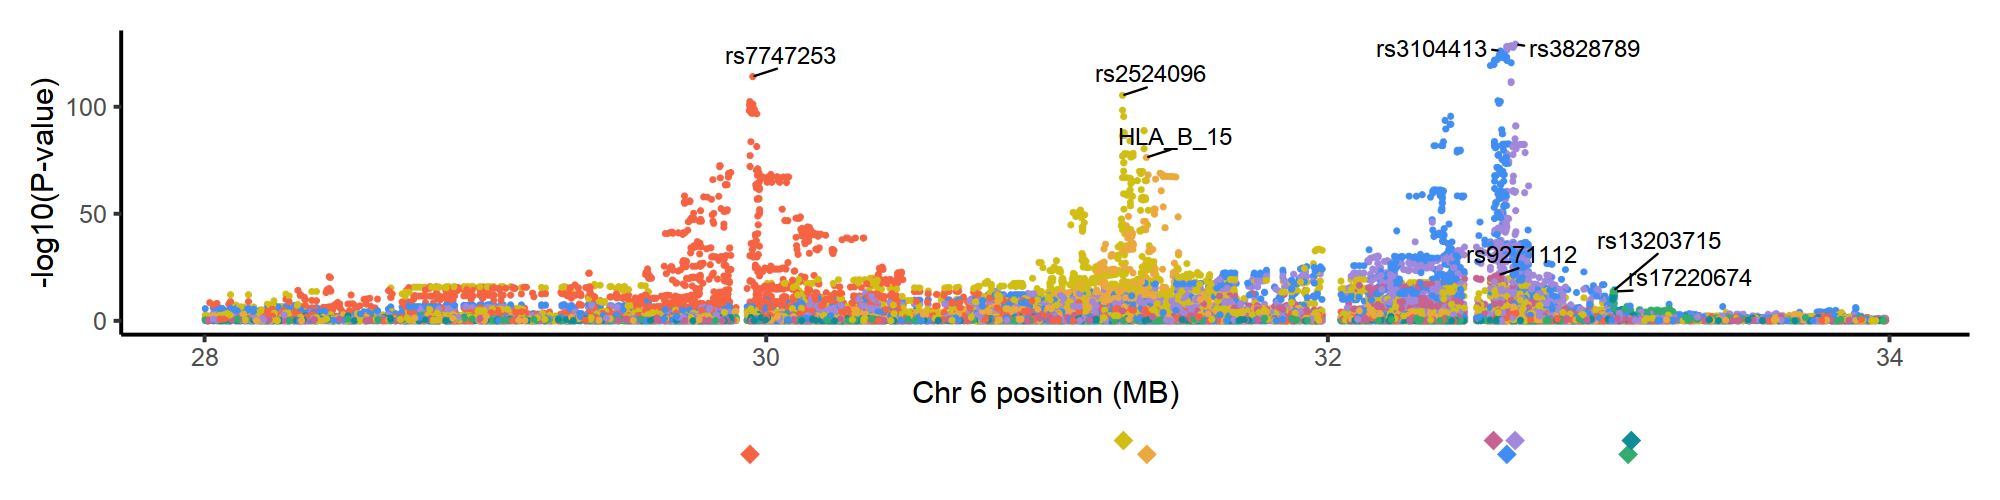

In [7]:
fig.size(2.5, 10)

set.seed(1)
p1 = results %>% 
        sample_frac(1L) %>% #shuffle
        ggplot() +
        geom_point_rast(aes(x = POS / 10^6, y = -log10(p.val), col = gene), size = 0.3) + 
        ylab('-log10(P-value)') + theme_classic() + xlab('Chr 6 position (MB)') +
        scale_color_manual(values = gene_colors) +
        theme(legend.position = 'none') + 
        guides(colour = guide_legend(override.aes = list(size = 4))) +
        geom_text_repel(data = lead_variants, aes(x = POS / 10^6, y = -log10(p.val), 
                               label = variant), size = 3, segment.size = 0.3, 
                               min.segment.length = 0, nudge_y = 10, nudge_x = 0.1) +
        xlim(28.002253, 33.985869)
p2 = ggplot(gtf_hla) +
        geom_point(aes(x = TSS / 10^6, y = plot_pos, col = hla_gene), size = 3, shape = 18) + 
        scale_color_manual(values = gene_colors) +
        theme_void() + theme(legend.position = 'none') + 
        xlim(28.002253, 33.985869) + ylim(-1, 1)

pdf(paste0('./Manhattan_Myeloid.pdf', sep = ''), height=2.5, width=10)
print(p1 / p2  + plot_layout(heights = c(5, 1)))
dev.off()
p1 / p2  + plot_layout(heights = c(5, 1))

In [8]:
sampleXdosage = readRDS('../eqtl_pseudobulk/4_multidataset_eQTLs/Myeloid_sampleXdosage.rds') 
residuals = readRDS('../eqtl_pseudobulk/4_multidataset_eQTLs/Myeloid_residuals.rds')
colnames(residuals) = str_replace(colnames(residuals), '\\.', '-')

sampleXdosage = sampleXdosage %>% round() %>% as.data.frame()
data = cbind(residuals, sampleXdosage)
data$dataset = factor(data$dataset, levels = c('AMP2RA', 'Smillie', 'Randolph_NI', 'OneK1K'))

The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph



png 
  2

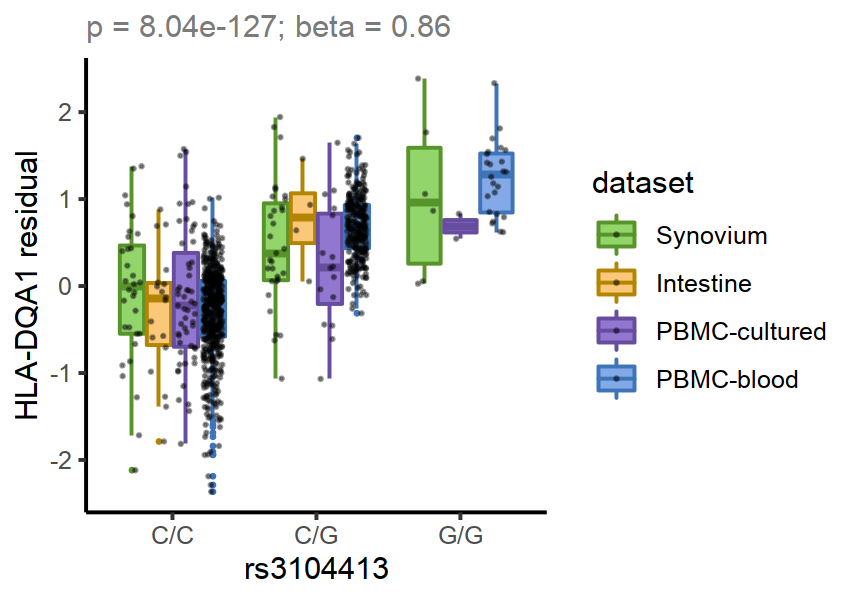

In [9]:
p = eqtl_boxplot_dataset('rs3104413', 'HLA-DQA1', data) + theme(legend.position = 'right')
fig.size(3, 4.25)
pdf(paste0('./HLA-DQA1_Myeloid_rs3104413_boxplot.pdf'), width = 4.25, height = 3)
print(p)
dev.off()
p

# Plot using tabix and LocusZoom

## Plot HLA-DQA1 conditional in Myeloid

Lead - primary

In [24]:
m = read.csv('../eqtl_pseudobulk/4_multidataset_eQTLs/Myeloid_all_variants.csv') %>%
    mutate(cell_type = 'Myeloid') %>% filter(gene == 'HLA-DQA1') %>% mutate(neglog10p = -log10(p.val)) %>%
    filter(!startsWith(variant, 'HLA')) # remove HLA alleles
m$X = NULL
m %>% slice(which.min(p.val))

m = m %>% arrange(POS)
dim(m)
write.table(m, '../SuppTables/tabix_HLA-DQA1_Myeloid.tsv', quote = F, sep = '\t', row.names = F)

m$POS = as.numeric(m$POS)
m = m %>% filter(POS > 32550000 & POS < 32700000)
m$direction = sign(m$beta)
m1 = m

variant,cell_type,gene,beta,stderr,t.val,p.val,CHROM,POS,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS,neglog10p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
rs3104413,Myeloid,HLA-DQA1,0.859,0.031,27.764,8.04e-127,chr6,32614873,C,G,0.99,IMP,0.31,0.09,0.14,0.2,32582650,126.0947


[1] 11938    19

Lead - secondary

In [25]:
m = read.csv('../eqtl_pseudobulk/6_multidataset_conditional/Myeloid_secondary_all_variants.csv', row.names = 1) %>%
    mutate(cell_type = 'Myeloid') %>% filter(gene == 'HLA.DQA1') %>% mutate(neglog10p = -log10(p.val)) %>%
    filter(!startsWith(variant, 'HLA')) # remove HLA alleles
m$X = NULL

m %>% slice(which.min(p.val))

m = m %>% arrange(POS)
dim(m)
write.table(m, '../SuppTables/tabix_HLA-DQA1_Myeloid_cond2.tsv', quote = F, sep = '\t', row.names = F)

m$POS = as.numeric(m$POS)
m = m %>% filter(POS > 32550000 & POS < 32700000)
m$direction = sign(m$beta)
m2 = m

variant,lead_variant,conditional_iter,cell_type,gene,beta,stderr,t.val,p.val,CHROM,⋯,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS,neglog10p
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
rs9272294,rs3104413,1,Myeloid,HLA.DQA1,-0.4614779,0.02687507,-17.17123,3.063829e-58,chr6,⋯,C,T,0.98,IMP,0.2028986,0.3825,0.1849315,0.2260726,32603760,57.51374


[1] 11937    21

### Generate LD values using MHC reference

`snp="rs3104413;6:32582650"`

`plink --vcf /data/srlab1/jkang/hla2023/data/MHC_reference/ALL3.merged.4digit.4field.conv.all_QC.ref_aligned.eagle.vcf --r2 --ld-snp ${snp} --ld-window 10000000 --ld-window-kb 5000 --ld-window-r2 0 --out /data/srlab1/jkang/hla2023/data/MHC_reference/LD/${snp}_MHC`

Joining, by = "variant"


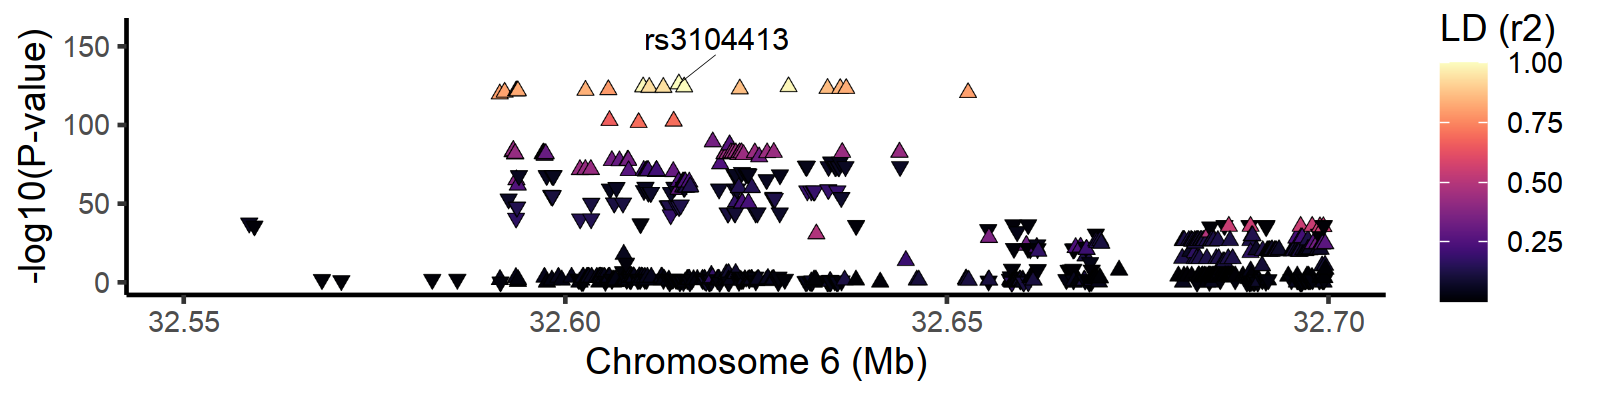

In [27]:
ld_res_rs3104413 = read.table('../data/MHC_reference/LD/rs3104413;6:32582650_MHC.ld', header = 1) %>% 
                    dplyr::select(SNP_B, R2) %>% mutate(SNP_B = sub(";.*", "", SNP_B)) %>% mutate(variant = SNP_B)

m1 = left_join(m1, ld_res_rs3104413)
m1_label = m1 %>% filter(variant == 'rs3104413')

fig.size(2, 8)
p1 = ggplot(m1) +
    geom_point_rast(aes(x = POS / 1e6, y = neglog10p, shape = as.factor(direction), fill = R2), size = 2, stroke = 0.2) + 
    geom_text_repel(data = m1_label, aes(x = POS / 1e6, y = neglog10p, label = variant), 
                    segment.size = 0.1, nudge_y = 50, nudge_x = 0.005, min.segment.length = 0) +
    theme_classic(base_size = 13) + labs(fill = 'LD (r2)') +
    xlab('Chromosome 6 (Mb)') + ylab('-log10(P-value)') +
    scale_shape_manual(values = c(25, 24), guide = "none") + ylim(0, 160) + scale_fill_viridis(option = 'magma') +
    scale_x_continuous(limits=c(32.55, 32.7))
p1

`snp="rs9272294;6:32603760"`

`plink --vcf /data/srlab1/jkang/hla2023/data/MHC_reference/ALL3.merged.4digit.4field.conv.all_QC.ref_aligned.eagle.vcf --r2 --ld-snp ${snp} --ld-window 10000000 --ld-window-kb 5000 --ld-window-r2 0 --out /data/srlab1/jkang/hla2023/data/MHC_reference/LD/${snp}_MHC`

Joining, by = "variant"


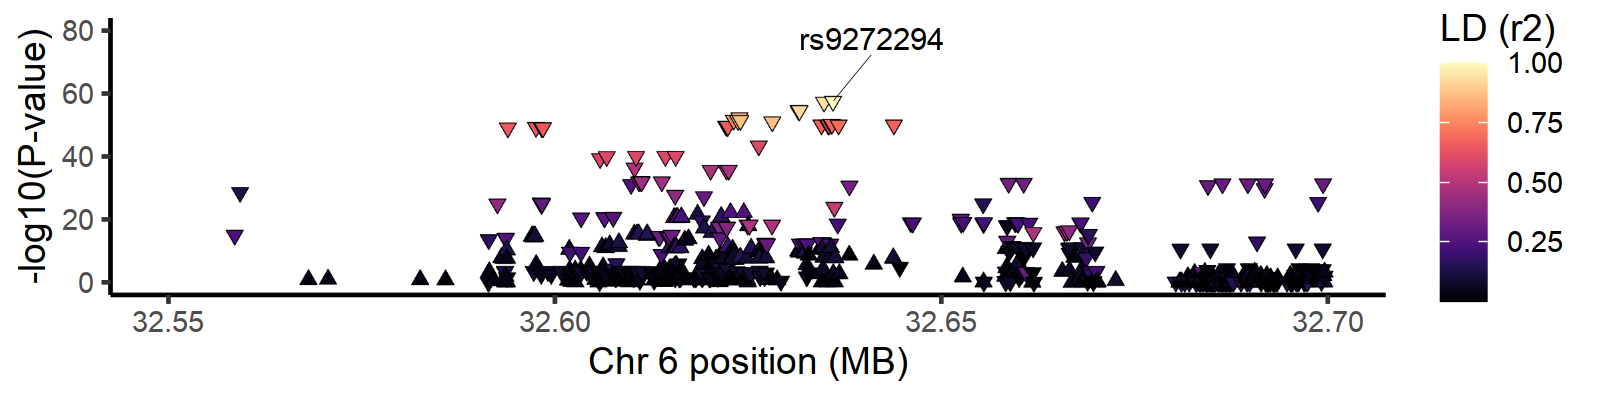

In [28]:
ld_res_rs9272294 = read.table('../data/MHC_reference/LD/rs9272294;6:32603760_MHC.ld', header = 1) %>% 
                    dplyr::select(SNP_B, R2) %>% mutate(SNP_B = sub(";.*", "", SNP_B)) %>% mutate(variant = SNP_B)

m2 = left_join(m2, ld_res_rs9272294)
m2_label = m2 %>% filter(variant == 'rs9272294')

p2 = ggplot(m2) +
    geom_point_rast(aes(x = POS / 1e6, y = neglog10p, shape = as.factor(direction), fill = R2), size = 2, stroke = 0.2) + 
    geom_text_repel(data = m2_label, aes(x = POS / 1e6, y = neglog10p, label = variant), segment.size = 0.1, nudge_y = 40, nudge_x = 0.005) +
    theme_classic(base_size = 13) + labs(fill = 'LD (r2)') +
    xlab('Chr 6 position (MB)') + ylab('-log10(P-value)') +
    scale_shape_manual(values = c(25, 24), guide = "none") + ylim(0, 80) + scale_fill_viridis(option = 'magma') +
    scale_x_continuous(limits=c(32.55, 32.7))
p2

png 
  2

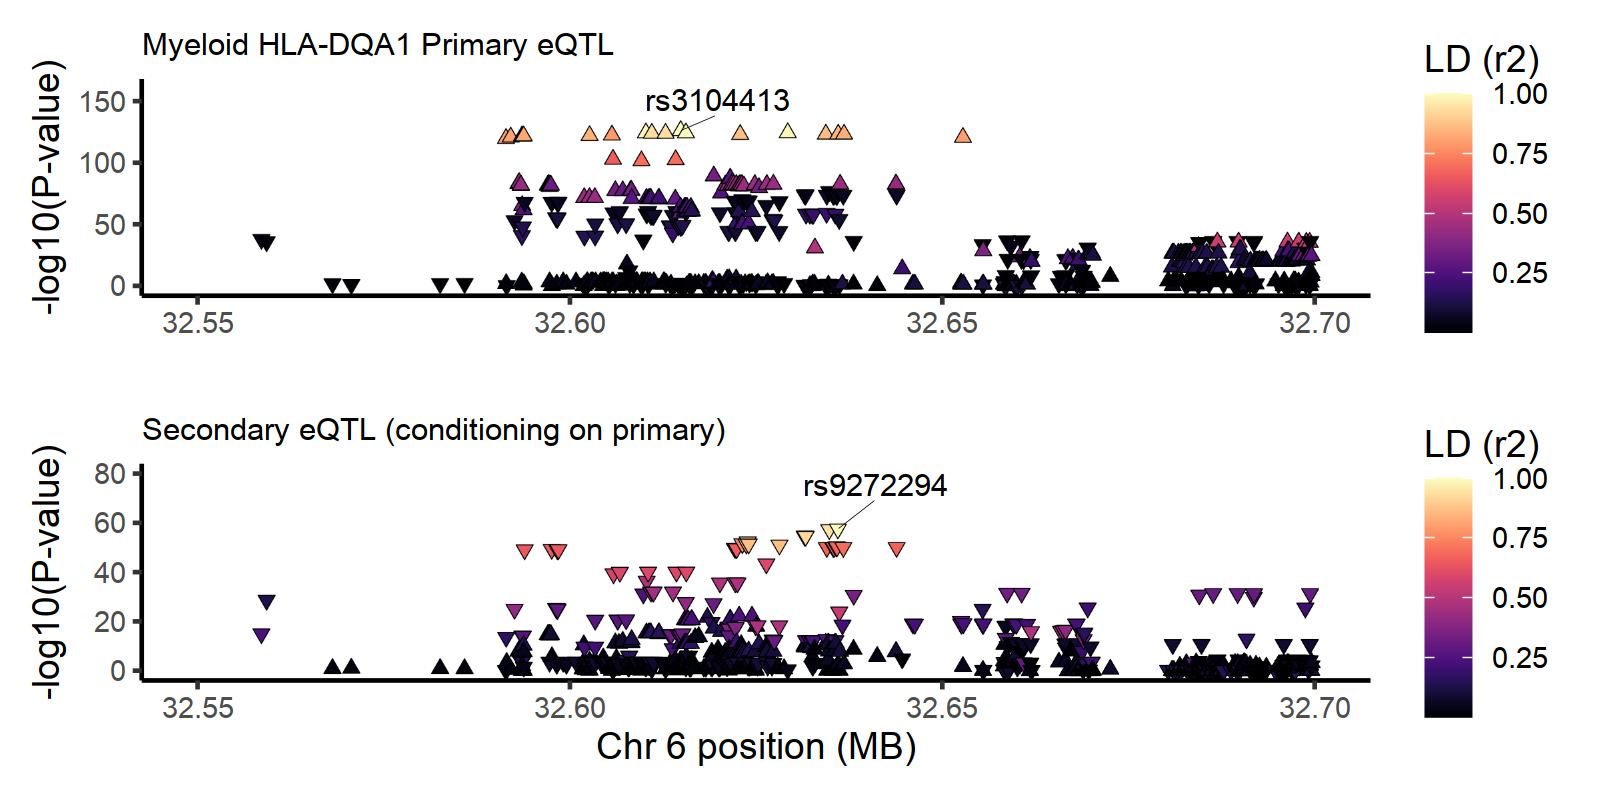

In [29]:
fig.size(4, 8)
p_comb = (p1 + xlab('') + ggtitle('Myeloid HLA-DQA1 Primary eQTL') + theme(plot.title = element_text(size = 11))) / 
         (p2 + ggtitle('Secondary eQTL (conditioning on primary)') + theme(plot.title = element_text(size = 11)))
pdf(paste0('./Myeloid_HLA-DQA1_LocusZoom_Conditional.pdf'), width = 8, height = 4)
print(p_comb)
dev.off()
p_comb

# Forest plot

In [11]:
# Multi dataset lead variants - Pers
B_plasma_results = read.csv('../eqtl_pseudobulk/4_multidataset_eQTLs/B_plasma_lead_variants.csv', row.names = 1)
Myeloid_results = read.csv('../eqtl_pseudobulk/4_multidataset_eQTLs/Myeloid_lead_variants.csv', row.names = 1)
T_results = read.csv('../eqtl_pseudobulk/4_multidataset_eQTLs/T_lead_variants.csv', row.names = 1) %>% 
    mutate(cell_type = 'T')
multi_dataset_result = rbind(B_plasma_results, Myeloid_results, T_results)
multi_dataset_result$dataset = 'multi-cohort'
multi_dataset_result = multi_dataset_result %>% mutate(label = paste(variant, gene, cell_type, sep = '_'))
head(multi_dataset_result, 3)

# Single dataset results
single_dataset_result = read.csv('../SuppTables/table_singledataset_pseudobulk_all.csv')
single_dataset_result$gene = str_replace(single_dataset_result$gene, '\\.', '-')
single_dataset_result = single_dataset_result %>% mutate(label = paste(variant, gene, cell_type, sep = '_')) %>% 
                                                filter(label %in% multi_dataset_result$label)
single_dataset_result$dataset = revalue(single_dataset_result$dataset, old_new_dataset_names)
single_dataset_result$dataset = factor(single_dataset_result$dataset, 
                                       levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
head(single_dataset_result, 3)

,variant,cell_type,gene,beta,stderr,t.val,p.val,CHROM,POS,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS,dataset,label
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,rs417162,B,HLA-A,0.5767157,0.02064114,27.94011,2.762306e-129,chr6,29948728,C,T,0.99,IMP,0.3913043,0.43227273,0.3013699,0.41364136,29916505,multi-cohort,rs417162_HLA-A_B
2,HLA_B_15,B,HLA-B,-1.1788444,0.04202419,-28.05157,4.570277e-130,chr6,31353886,A,T,0.95,IMP,0.1014493,0.09090909,0.1438356,0.07150715,31321663,multi-cohort,HLA_B_15_HLA-B_B
3,HLA_C_07,B,HLA-C,-0.8859126,0.02247189,-39.42314,2.872157e-210,chr6,31268774,A,T,0.98,IMP,0.3478261,0.29545455,0.2123288,0.34268427,31236551,multi-cohort,HLA_C_07_HLA-C_B


The following `from` values were not present in `x`: Smillie2019, Randolph2021, Randolph



,variant,cell_type,gene,dataset,beta,stderr,t.val,p.val,REF,ALT,label
,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,rs417162,B,HLA-A,Synovium,0.440,0.114,3.856,2.73e-04,C,T,rs417162_HLA-A_B
2,rs417162,B,HLA-A,PBMC-blood,0.580,0.021,27.585,4.07e-122,C,T,rs417162_HLA-A_B
3,rs417162,B,HLA-A,PBMC-cultured,0.593,0.102,5.835,1.47e-07,C,T,rs417162_HLA-A_B


In [12]:
single_dataset_result$ID = NULL
dim(single_dataset_result)
combined_result = rbind.fill(single_dataset_result, multi_dataset_result)
combined_result = combined_result %>% mutate(lower = beta - 1.96*stderr,
                                             upper = beta + 1.96*stderr)

combined_result$dataset = factor(combined_result$dataset, 
                                 levels = rev(c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood', 'multi-cohort')))
levels(combined_result$dataset)

[1] 96 11

[1] "multi-cohort"  "PBMC-blood"    "PBMC-cultured" "Intestine"    
[5] "Synovium"

In [13]:
combined_result$sign = combined_result$beta >= 0

combined_result = combined_result %>% mutate(pop_size = case_when(dataset == 'Synovium' ~ 69,
                                                         dataset == 'Intestine' ~ 22,
                                                         dataset == 'PBMC-cultured' ~ 73,
                                                         dataset == 'PBMC-blood' ~ 909,
                                                         dataset == 'multi-cohort' ~ 1073))

combined_result$shape = ifelse(combined_result$dataset == 'multi-cohort', 18, 16) %>% as.factor()

# Label REF and ALT for variants (but not HLA alleles)
multi_dataset_result = multi_dataset_result %>% 
    mutate(variant = ifelse(startsWith(variant, 'HLA'), variant, paste(variant, REF, ALT, sep = '_')))

In [14]:
info = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
info %>% filter(startsWith(ID, 'SNPS_B_488') | startsWith(ID, 'HLA_B_15'))
multi_dataset_result$X = NULL

CHROM,POS,ID,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr6,31353886,HLA_B_15,A,T,0.95,IMP,0.10144928,0.09090909,0.14383562,0.07150715,31321663
chr6,31353887,HLA_B_15.01,A,T,0.91,IMP,0.06521739,0.06772727,0.02739726,0.06765677,31321664


In [15]:
multi_dataset_result$variant

[1] "rs417162_C_T"   "HLA_B_15"       "HLA_C_07"       "rs2163472_C_T" 
 [5] "rs2395305_A_T"  "rs9271375_G_A"  "rs9272346_G_A"  "rs9271117_C_T" 
 [9] "rs7747253_C_A"  "HLA_B_15"       "rs2524096_G_T"  "rs17220674_G_A"
[13] "rs13203715_A_G" "rs3104413_C_G"  "rs3828789_G_T"  "rs9271112_T_C" 
[17] "rs7747253_C_A"  "HLA_B_15"       "rs2395471_G_A"  "HLA_DPB1_04.02"
[21] "rs1431403_T_C"  "rs3104371_C_G"  "rs9272271_A_T"  "rs17205184_G_A"

In [16]:
combined_result$cell_type = factor(combined_result$cell_type, levels = c('Myeloid', 'B', 'T'))
combined_result$gene = factor(combined_result$gene, 
                    levels = c('HLA-A', 'HLA-C', 'HLA-B', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1'))

## Write supp table

In [17]:
combined_result %>% dplyr::select(variant, cell_type, gene, dataset, beta, stderr, p.val, REF, ALT) %>%
            mutate(beta = round(beta, 3), stderr = round(stderr, 3), 
            p.val = format(p.val, digits = 3, scientific = TRUE)) %>% arrange(cell_type, gene) %>% 
write.csv('../SuppTables/table_single_multi_lead_comparison.csv', quote = F)

## Plot and calc mean directional concordance

png 
  2

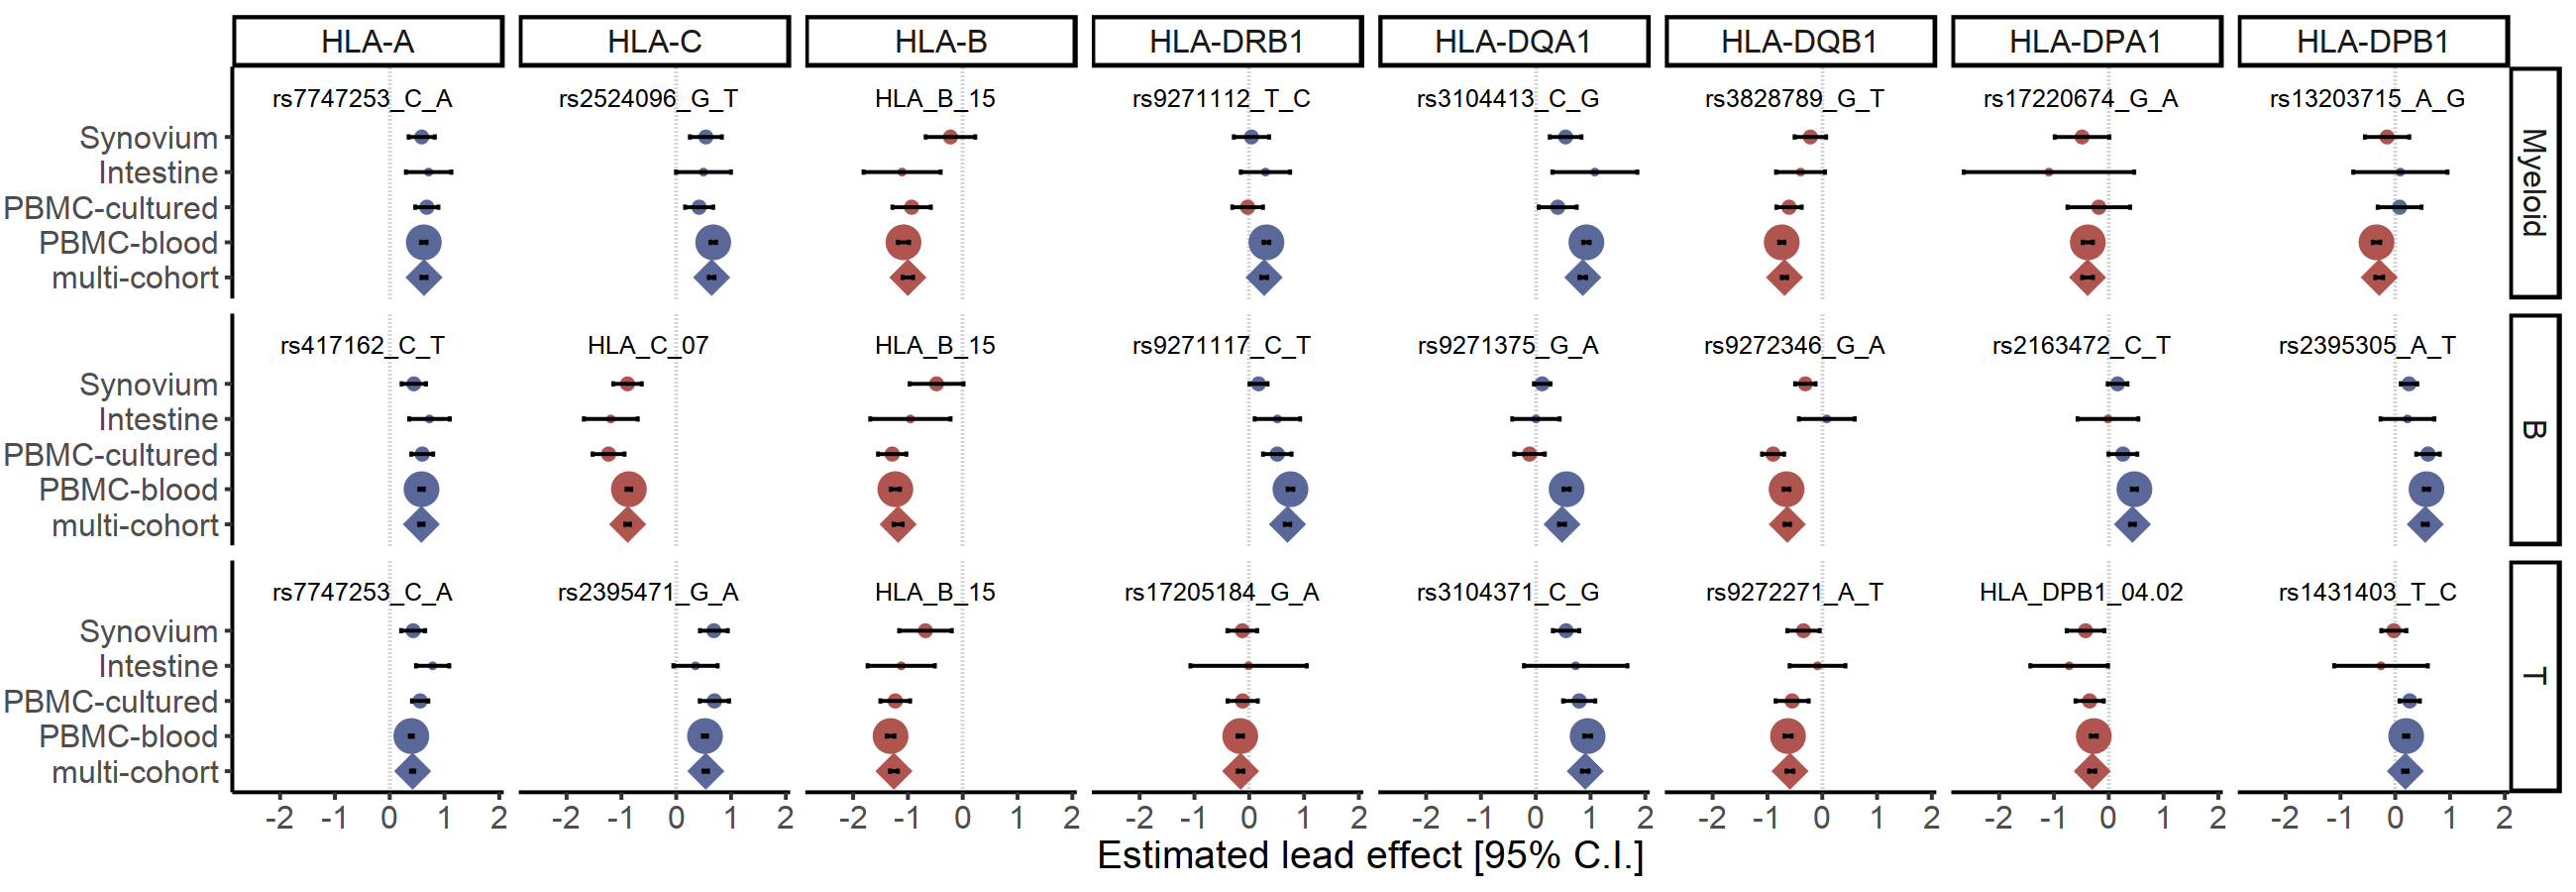

In [18]:
fig.size(4.5, 13)
pdf(paste0('./Forest_plot_multi.pdf'), height=4.5, width=13)
fp = ggplot(data=combined_result) +
        geom_hline(yintercept=0, lty=3, col = 'darkgrey') +  # add a dotted line at x=0 after flip
        geom_point( aes(x=dataset, y=beta, col = sign, size = pop_size, shape = shape)) + 
        geom_errorbar(aes(x=dataset, y=beta, col = sign, ymin = upper, ymax = lower), col = 'black', width = 0.15) + 
        theme_classic() + 
        geom_text(size = 3.1, data = multi_dataset_result,
            mapping = aes(x = 6.1, y = -0.5, label = variant)) + expand_limits(x = 7) +
        coord_flip() +
        xlab(NULL) + ylab("Estimated lead effect [95% C.I.]") + scale_color_manual(values = c('#b0544f', '#5a6899')) +
        theme(legend.position = 'none') + scale_shape_manual(values=c('18' = 18, '16' = 16)) +
        facet_grid(factor(cell_type) ~ factor(gene)) + 
        theme(text = element_text(size=14)) 
print(fp)
dev.off()
fp

In [19]:
# How many discordant? 8 out of 24*4
((24*4) - 8)/ (24*4)
((24*4) - 8)
(24*4)

[1] 0.9166667

[1] 88

[1] 96

In [20]:
(23/24 + 20/24 + 21/24 + 24/24) / 4

[1] 0.9166667

# Cell type dependent eQTL

For Panel 3e, please see the notebook `../eqtl_pseudobulk/4_plot_multidataset_result.ipynb`

# Done!

In [21]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] coloc_5.1.0.1           readxl_1.3.1            gdata_2.18.0           
 [4] viridis_0.6.2           viridisLite_0.4.1       ggrepel_0.9.1          
 [7] ggrastr_1.0.1           gridExtra_2.3           fitdistrplus_1.1-8     
[10] survival_3.3-1          purrr_